# 1. Imports

In [1]:
import pandas as pd
import numpy as np
from absl import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import seaborn as sns
from tqdm import tqdm




dat = pd.read_csv('../Data/HMTG_pilot_2raters_5_6_22.csv', sep=',', index_col=0)

# 2. Feature selection
## removing stop-words

In [2]:
# we need to drop subject 8 (observed IA) and 65 (observed GA), then we want to drop a random subject from those that observed MO and GR
#dat = dat[~dat.loc[dat.subject_id == 8]]
dat.drop(dat.index[dat['subject_id'] == 8], inplace=True)
dat.drop(dat.index[dat['subject_id'] == 65], inplace=True)
mosubs = dat.loc[dat.p2_strategy == 'MO'].subject_id.unique()
dat.drop(dat.index[dat['subject_id'] == mosubs[np.random.randint(len(mosubs))]], inplace=True)
grsubs = dat.loc[dat.p2_strategy == 'GR'].subject_id.unique()
dat.drop(dat.index[dat['subject_id'] == grsubs[np.random.randint(len(mosubs))]], inplace=True)
dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))


,subject_id
trustee_id,
54,12
62,12
93,12
97,12


In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwds = stopwords.words('english')
stopwds.remove('more')

dat['rsn_no_sw'] = None
for text in tqdm(dat.loc[dat.probe_trl== True].reason.values):
    text_tokens = word_tokenize(text)
    token_wout_sw = [word for word in text_tokens if not word in stopwds]
    newR = ' '.join(token_wout_sw)
    dat.loc[dat.reason == text, 'rsn_no_sw'] = newR



100%|██████████| 543/543 [00:00<00:00, 1362.60it/s]


# 2. Make Embeddings with USE

In [10]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

def embed(input):
  return model(input)

OSError: SavedModel file does not exist at: /var/folders/y8/dlx7ymv947174gtwpprrtw380000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c/{saved_model.pbtxt|saved_model.pb}

In [ ]:

def time_point_embeddings(t, strategy=None):
    '''
    This function returns the embeddings associated with each subject's text response for a given probe number

    :param t:  takes as input the probe number
    :return: dictionary mapping subject to semantic embedding of the reason given at the t-th probe.
    '''
    if strategy:
        tdat = dat.loc[(dat.probe_num == t) & (dat.p2_strategy == strategy)]
    else:
        tdat = dat.loc[dat.probe_num == t]
    t1_reasons = [dat.loc[(dat.probe_num == t) & (dat.subject_id == ss) ].reason.values[0] for ss in tdat.subject_id.unique()]
    #e0 = embed(t1_reasons)
    return {ss:embed([t1_reasons[e]]) for e,ss in enumerate(tdat.subject_id.unique()) }

def pairwise_embed_dists(sub_embeddings):
    '''
    this function computes the across-subject pairwise distances of embeddings

    :param sub_embeddings: A dictionary mapping subject to response embedding for a single timepoint
    :return: pandas dataframe of subject x subject pairwise distances of embeddings
    '''
    p0 = pd.DataFrame(index=sub_embeddings.keys(), columns=sub_embeddings.keys())
    for subject in sub_embeddings.keys():
        for othersub in sub_embeddings.keys():
            p0.at[subject, othersub] = np.linalg.norm(sub_embeddings[subject] - sub_embeddings[othersub])

    for col in p0.columns:
            p0[col] = p0[col].astype(float) #
    return p0

Before computing pairwise distances I have to make sure all subjects have the same number of probes.

In [ ]:
p_nums = {subj: dat.loc[dat.subject_id == subj].probe_num.max() for subj in dat.subject_id.unique()}
pp = pd.DataFrame(p_nums, index={'counts':[0]}).T.reset_index().rename(columns={'index':'subjects'})
sns.catplot(x='subjects', y='counts', data=pp, kind='bar')

In [ ]:
p_nums = {subj: dat.loc[dat.subject_id == subj].probe_num.max() for subj in dat.subject_id.unique()}
pp = pd.DataFrame(p_nums, index={'counts':[0]}).T.reset_index().rename(columns={'index':'subjects'})
sns.catplot(x='subjects', y='counts', data=pp, kind='bar')

In [3]:
max_probe = 10 #int(dat.probe_num.max())
dists = pd.DataFrame({'probe_num': list(range(max_probe+1)) * len(dat.p2_strategy.unique()),
                      'sum_dists': 0,
                      'strat_observed':np.repeat([strat for strat in dat.p2_strategy.unique()], int(max_probe+1))
                      })

for strat in tqdm(dat.p2_strategy.unique()):
    for t in range(max_probe+1):
        s_embed_0 = time_point_embeddings(t, strategy=strat)
        p0 = pairwise_embed_dists(s_embed_0)
        p0_bttm_triangle = p0.where(~np.triu(np.ones(p0.shape)).astype(bool)) # gives you just the bottom triangle
        dists.loc[(dists.probe_num == t) & (dists.strat_observed == strat), 'sum_dists'] = sum(p0_bttm_triangle.sum()) #sum down rows, then across columns


  0%|          | 0/4 [00:00<?, ?it/s]


NameError: name 'time_point_embeddings' is not defined

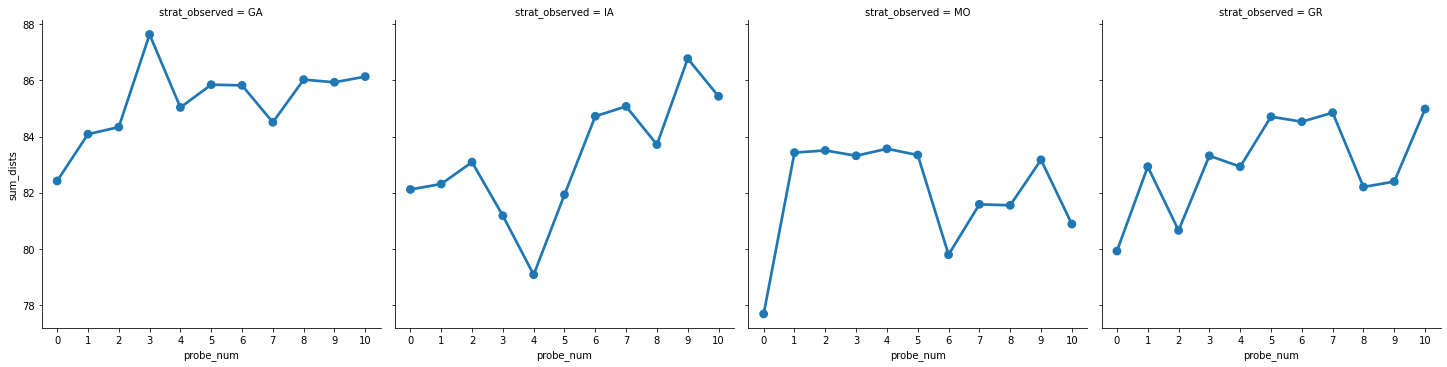

In [26]:
# Correct for differences in the number ofg probes. All subs should have same number of probes. 
sns.catplot(x='probe_num', y='sum_dists', kind='point', col='strat_observed', data=dists)

# 3. Clustering: HDBSCAN

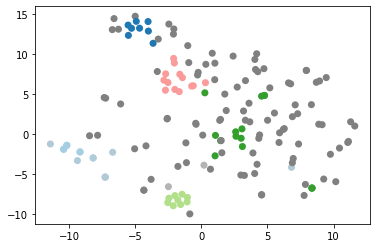

In [28]:
import hdbscan
from sklearn.manifold import TSNE

# Get a list of all reasons
reasons = dat.loc[(dat.probe_trl == True) & (dat.probe_num >= 8)].reason.tolist()
e0 = embed(reasons)
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, cluster_selection_epsilon=.5).fit(e0)
cc = clusterer.labels_
learned = dat.loc[(dat.probe_trl == True) & (dat.probe_num >= 8)].reset_index(drop=True)
learned['reason_clust'] = cc
projection = TSNE().fit_transform(e0)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors)

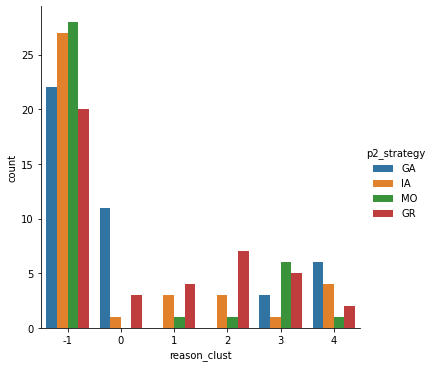

In [29]:
sns.catplot(data=learned, x='reason_clust', hue='p2_strategy', kind='count')

In [40]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.sequence import pad_sequences

X_train_counts = CountVectorizer().fit_transform(dat.loc[dat.probe_trl == True].reason.values)
X_train_tfidf = TfidfTransformer().fit_transform(X=X_train_counts)

Using TensorFlow backend.


In [47]:
docs = dat.loc[dat.probe_trl ==True].reason.values
docs=[d.lower() for d in docs] # make everything lower case

count_vect = CountVectorizer().fit(docs) # maps every word to a unique arbitrary integer from the vocabulary
tokenizer = count_vect.build_tokenizer() # initialize a tokenizer

input_array = []
for doc in docs:
    x=[]
    for token in tokenizer(doc):
        x.append(count_vect.vocabulary_.get(token))
    input_array.append(x)

max_len = max([len(d) for d in input_array])
input_array = pad_sequences(input_array, maxlen=max_len, padding='post')

In [48]:
def tsne_plot(model,max_words=100):
    labels = []
    tokens = []

    n=0
    for word in model:
        if n<max_words:
            tokens.append(model[word])
            labels.append(word)
            n+=1


    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(8, 8))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [49]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten,Dense
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [53]:
model = Sequential()
model.add(Embedding(input_dim=55, output_dim=8))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
M={}
for i in range(len(input_array)):
    for j in range(len(input_array[i])):
        M[input_array[i][j]]=output_array[i][j]

tsne_plot(M)

InvalidArgumentError:  indices[0,0] = 599 is not in [0, 55)
	 [[node embedding_4/embedding_lookup (defined at /Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_23946]

Function call stack:
keras_scratch_graph


In [45]:
input_array = np.random.randint(100, size=(10, 10))

In [46]:
input_array

array([[45, 83, 68, 67,  1, 51, 38,  4, 11, 59],
       [77, 97, 28,  1, 94,  6, 19, 46, 63, 87],
       [31, 39, 60, 89, 17, 67, 21, 97, 50, 90],
       [80, 88, 56, 24, 97,  7, 34, 77, 21, 16],
       [50, 75, 94, 75, 62, 88, 95, 60, 61,  6],
       [68, 21, 37, 40, 63, 39, 87, 16,  6, 92],
       [55, 97, 79, 36, 99, 54, 30, 38, 28, 53],
       [85, 77, 62, 93, 21, 87, 94, 65, 80, 28],
       [90, 79, 78, 92, 76,  2, 28, 96,  8, 26],
       [80,  5, 40, 68, 97, 75, 67, 54, 52, 87]])